In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm

In [77]:
# Engle-Granger
def EG_method(X, Y, show_summary=False):
    # Step 1: Long-run equilibrium regression (Y = α + βX + ε)
    model1 = sm.OLS(Y, sm.add_constant(X)).fit()  # Y = α + βX + ε
    epsilon = model1.resid  # ε

    if show_summary:
        print("\n Step 1: Long-run regression result \n")
        print(model1.summary())

    # Cointegration test: ADF test on residuals ε
    adf_p_value = sm.tsa.stattools.adfuller(epsilon)[1]
    if adf_p_value > 0.05:
        return False, model1

    # Step 2: Build ECM
    #ΔY ~ ΔX + ε_{t-1}
    X_dif = sm.add_constant(pd.concat([X.diff(), epsilon.shift(1)], axis=1).dropna())
    Y_dif = Y.diff().dropna()

    model2 = sm.OLS(Y_dif, X_dif).fit() 

    if show_summary:
        print("Step 2: Error Correction Model result \n")
        print(model2.summary())

    # Check if λ is negative
    lambda_coeff = list(model2.params)[-1]  # ε_{t-1} coefficient
    if lambda_coeff > 0:
        return False, model1
    else:
        return True, model1


In [78]:
data = yf.download(['AAPL', 'MSFT'], start='2024-01-01', end='2025-5-17')['Close']
display(data.head())
X = data['AAPL']
Y = data['MSFT']
is_coint, model = EG_method(X, Y, show_summary=True)

print("\n Cointegration status:", is_coint)

[*********************100%***********************]  2 of 2 completed


Ticker,AAPL,MSFT
Date,,
2024-01-02,184.290436,366.707336
2024-01-03,182.910522,366.440460
2024-01-04,180.587540,363.810272
2024-01-05,179.862823,363.622437
2024-01-08,184.210999,370.484528



 Step 1: Long-run regression result 

                            OLS Regression Results                            
Dep. Variable:                   MSFT   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     51.62
Date:                Tue, 20 May 2025   Prob (F-statistic):           4.22e-12
Time:                        05:39:08   Log-Likelihood:                -1512.5
No. Observations:                 345   AIC:                             3029.
Df Residuals:                     343   BIC:                             3037.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

In [79]:
data = yf.download(['KO', 'PEP'], start='2024-01-01', end='2025-5-17')['Close']
display(data.head())
X = data['KO']
Y = data['PEP']
is_coint, model = EG_method(X, Y, show_summary=True)

print("\n Cointegration status:", is_coint)

[*********************100%***********************]  2 of 2 completed


Ticker,KO,PEP
Date,,
2024-01-02,57.621922,166.076355
2024-01-03,57.756783,166.114777
2024-01-04,57.564125,164.693253
2024-01-05,57.477428,162.263260
2024-01-08,57.901264,162.426544



 Step 1: Long-run regression result 

                            OLS Regression Results                            
Dep. Variable:                    PEP   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     32.74
Date:                Tue, 20 May 2025   Prob (F-statistic):           2.29e-08
Time:                        05:39:08   Log-Likelihood:                -1295.8
No. Observations:                 345   AIC:                             2596.
Df Residuals:                     343   BIC:                             2603.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

In [80]:
data = yf.download(['XOM', 'CVX'], start='2023-01-01', end='2025-5-17')['Close']
display(data.head())
X = data['XOM']
Y = data['CVX']
is_coint, model = EG_method(X, Y, show_summary=True)

print("\n Cointegration status:", is_coint)

[*********************100%***********************]  2 of 2 completed


Ticker,CVX,XOM
Date,,
2023-01-03,158.737152,97.812386
2023-01-04,157.049316,98.097061
2023-01-05,159.877548,100.291901
2023-01-06,161.081833,101.504105
2023-01-09,159.822815,99.612335



 Step 1: Long-run regression result 

                            OLS Regression Results                            
Dep. Variable:                    CVX   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     202.7
Date:                Tue, 20 May 2025   Prob (F-statistic):           8.99e-40
Time:                        05:39:08   Log-Likelihood:                -1961.2
No. Observations:                 595   AIC:                             3926.
Df Residuals:                     593   BIC:                             3935.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

In [81]:
def signal_generation(asset1, asset2, method, bandwidth=10):    
    signals = pd.DataFrame()
    signals['asset1'] = asset1['Close']
    signals['asset2'] = asset2['Close']

    signals['signals1'] = 0    
    signals['signals2'] = 0

    prev_status = False
    signals['z'] = np.nan
    signals['z upper limit'] = np.nan
    signals['z lower limit'] = np.nan
    signals['fitted'] = np.nan    
    signals['residual'] = np.nan

    col_idx = {col: signals.columns.get_loc(col) for col in [
        'signals1', 'signals2', 'z', 'z upper limit', 'z lower limit', 'fitted', 'residual'
    ]}

    for i in range(bandwidth, len(signals)):
        coint_status, model = method(
            signals['asset1'].iloc[i - bandwidth:i],
            signals['asset2'].iloc[i - bandwidth:i])

        if prev_status and not coint_status:
            if signals.iat[i - 1, col_idx['signals1']] != 0:
                signals.iat[i, col_idx['signals1']] = 0
                signals.iat[i, col_idx['signals2']] = 0
                signals.iloc[i:, [col_idx['z'], col_idx['z upper limit'], col_idx['z lower limit'],
                                  col_idx['fitted'], col_idx['residual']]] = np.nan

        if not prev_status and coint_status:
            fitted = model.predict(sm.add_constant(signals['asset1'].iloc[i:]))
            residual = signals['asset2'].iloc[i:] - fitted
            z = (residual - np.mean(model.resid)) / np.std(model.resid)
            z_upper = z.iloc[0] + np.std(model.resid)
            z_lower = z.iloc[0] - np.std(model.resid)

            signals.iloc[i:, col_idx['fitted']] = fitted.values
            signals.iloc[i:, col_idx['residual']] = residual.values
            signals.iloc[i:, col_idx['z']] = z.values
            signals.iloc[i:, col_idx['z upper limit']] = z_upper
            signals.iloc[i:, col_idx['z lower limit']] = z_lower

        if coint_status and signals.iat[i, col_idx['z']] > signals.iat[i, col_idx['z upper limit']]:
            signals.iat[i, col_idx['signals1']] = 1
        if coint_status and signals.iat[i, col_idx['z']] < signals.iat[i, col_idx['z lower limit']]:
            signals.iat[i, col_idx['signals1']] = -1

        prev_status = coint_status

    signals['positions1'] = signals['signals1'].diff()
    signals['signals2'] = -signals['signals1']
    signals['positions2'] = signals['signals2'].diff()

    return signals


In [82]:
data = yf.download(['AAPL', 'MSFT'], start='2024-01-01', end='2025-5-17')['Close']
asset1 = pd.DataFrame({'Close': data['AAPL']})
asset2 = pd.DataFrame({'Close': data['MSFT']})


[*********************100%***********************]  2 of 2 completed


In [83]:
signals = signal_generation(asset1, asset2, method=EG_method, bandwidth=200)

In [84]:
signals

,asset1,asset2,signals1,signals2,z,z upper limit,z lower limit,fitted,residual,positions1,positions2
Date,,,,,,,,,,,
2024-01-02,184.290436,366.707336,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-03,182.910522,366.440460,0,0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2024-01-04,180.587540,363.810272,0,0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2024-01-05,179.862823,363.622437,0,0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2024-01-08,184.210999,370.484528,0,0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2025-05-12,210.789993,448.436737,0,0,3.143868,18.585425,-12.724913,399.218954,49.217783,0.0,0.0
2025-05-13,212.929993,448.316986,0,0,3.020404,18.585425,-12.724913,401.032058,47.284928,0.0,0.0
2025-05-14,212.330002,452.109985,0,0,3.295159,18.585425,-12.724913,400.523719,51.586267,0.0,0.0


In [85]:
def plot(data, ticker1, ticker2):    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()

    price1, = ax1.plot(data.index, data['asset1'], color='#113aac', alpha=0.7, label=ticker1)
    price2, = ax2.plot(data.index, data['asset2'], color='#907163', alpha=0.7, label=ticker2)
    # Plot asset1 signals
    long1 = ax1.plot(data.loc[data['positions1'] == 1].index,
                     data.loc[data['positions1'] == 1, 'asset1'],
                     lw=0, marker='^', markersize=8, color='g', alpha=0.7, label=f'{ticker1} LONG')
    
    short1 = ax1.plot(data.loc[data['positions1'] == -1].index,
                      data.loc[data['positions1'] == -1, 'asset1'],
                      lw=0, marker='v', markersize=8, color='r', alpha=0.7, label=f'{ticker1} SHORT')

    # Plot asset2 signals
    long2 = ax2.plot(data.loc[data['positions2'] == 1].index,
                     data.loc[data['positions2'] == 1, 'asset2'],
                     lw=0, marker='^', markersize=8, color='g', alpha=0.7, label=f'{ticker2} LONG')
    
    short2 = ax2.plot(data.loc[data['positions2'] == -1].index,
                      data.loc[data['positions2'] == -1, 'asset2'],
                      lw=0, marker='v', markersize=8, color='r', alpha=0.7, label=f'{ticker2} SHORT')

    ax1.set_ylabel(ticker1)
    ax2.set_ylabel(ticker2)
    ax1.set_xlabel('Date')

    ax1.set_title('Pair Trading Positions')
    ax1.grid(True)

    handles = [price1, price2] + long1 + short1 + long2 + short2
    labels = [h.get_label() for h in handles]
    ax1.legend(handles, labels, loc='lower left')

    plt.tight_layout()
    plt.show()


In [86]:
def portfolio(data):
    capital0 = 20000
    data = data.copy()
    positions1 = capital0 // data['asset1'].max()
    positions2 = capital0 // data['asset2'].max()

    data['cumsum1'] = data['positions1'].cumsum()
    data['cumsum2'] = data['positions2'].cumsum()

    portfolio = pd.DataFrame(index=data.index)
    
    # asset1
    portfolio['asset1'] = data['asset1']
    portfolio['positions1'] = data['positions1']
    portfolio['holdings1'] = data['cumsum1'] * data['asset1'] * positions1
    portfolio['cash1'] = capital0 - (data['positions1'] * data['asset1'] * positions1).cumsum()
    portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
    portfolio['return1'] = portfolio['total asset1'].pct_change()

    # asset2
    portfolio['asset2'] = data['asset2']
    portfolio['positions2'] = data['positions2']
    portfolio['holdings2'] = data['cumsum2'] * data['asset2'] * positions2
    portfolio['cash2'] = capital0 - (data['positions2'] * data['asset2'] * positions2).cumsum()
    portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
    portfolio['return2'] = portfolio['total asset2'].pct_change()

    portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
    portfolio['z'] = data['z']
    portfolio['z upper limit'] = data['z upper limit']
    portfolio['z lower limit'] = data['z lower limit']

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()

    total_line, = ax1.plot(portfolio.index, portfolio['total asset'], color='#46344e', label='Total Asset Performance')

    z_line, = ax2.plot(portfolio.index, portfolio['z'], color='#4f4a41', alpha=0.2, label='Z Statistics')
    z_band = ax2.fill_between(portfolio.index,
                              portfolio['z upper limit'],
                              portfolio['z lower limit'],
                              alpha=0.2, color='#ffb48f', label='Z Statistics ±1 Sigma')

    ax1.set_ylabel('Asset Value')
    ax2.set_ylabel('Z Statistics', rotation=270, labelpad=15)
    ax1.set_xlabel('Date')

    ax1.legend(loc='best')
    ax1.grid(True)
    ax1.set_title('Portfolio Value and Z Statistics')
    plt.tight_layout()
    plt.show()

    return portfolio


In [87]:
stdate = '2023-01-01'
eddate = '2025-5-17'
ticker1 = 'XOM'
ticker2 = 'CVX'
asset1 = yf.download(ticker1, start=stdate, end=eddate)
asset2 = yf.download(ticker2, start=stdate, end=eddate)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [88]:
signals = signal_generation(asset1, asset2, EG_method)
ind = signals['z'].dropna().index[0]
signals.loc[ind:].head()

,asset1,asset2,signals1,signals2,z,z upper limit,z lower limit,fitted,residual,positions1,positions2
Date,,,,,,,,,,,
2023-01-18,101.577583,161.693115,0,0,0.865878,1.915028,-0.183273,160.784679,0.908436,0.0,0.0
2023-01-19,102.229607,163.307938,0,0,1.939905,1.915028,-0.183273,161.272686,2.035252,0.0,0.0
2023-01-20,104.093826,165.041367,0,0,1.899327,3.037124,0.761530,162.880318,2.161048,0.0,0.0
2023-01-23,103.552017,164.822433,0,0,2.036241,3.037124,0.761530,162.505605,2.316829,0.0,0.0
2023-01-24,104.516258,164.977509,0,0,1.586432,3.037124,0.761530,163.172471,1.805038,0.0,0.0


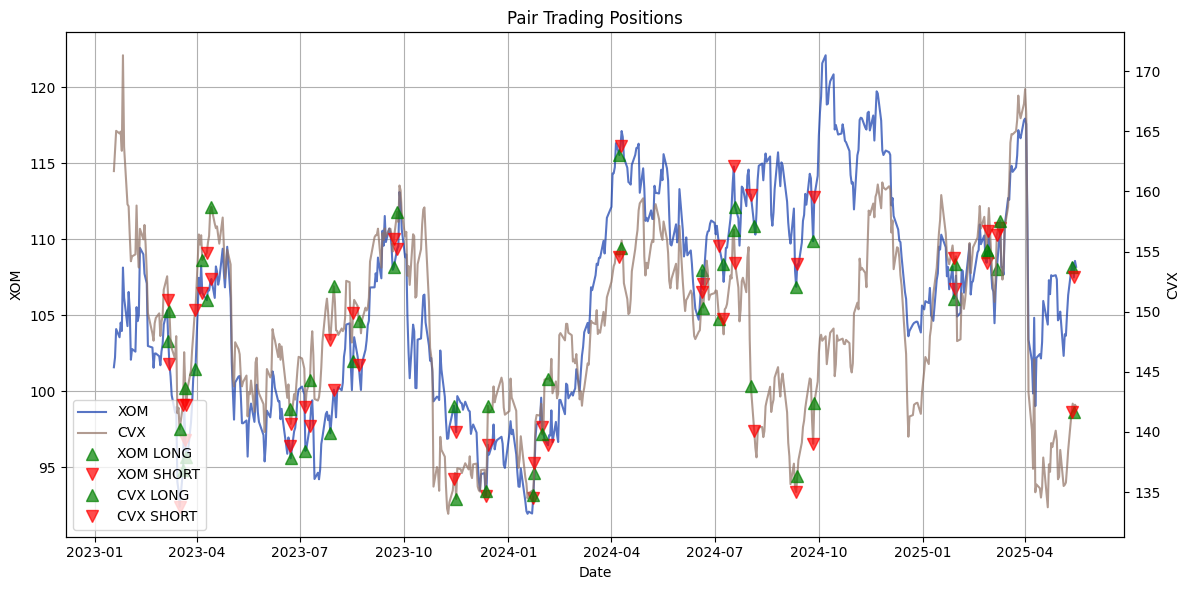

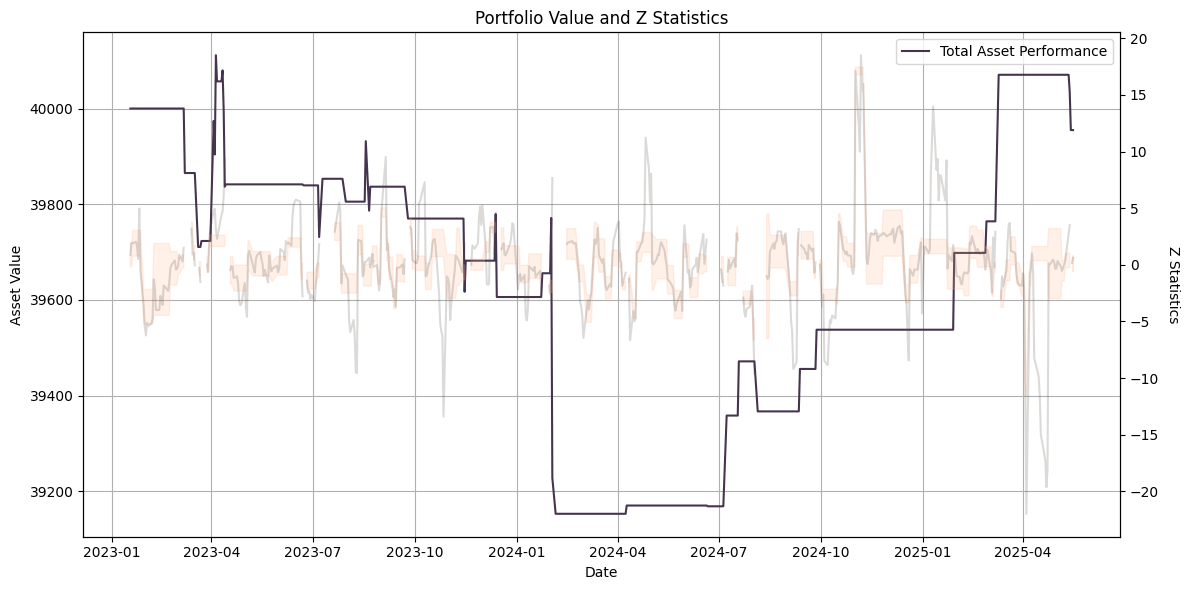

,asset1,positions1,holdings1,cash1,total asset1,return1,asset2,positions2,holdings2,cash2,total asset2,return2,total asset,z,z upper limit,z lower limit
Date,,,,,,,,,,,,,,,,
2025-05-12,108.163795,1.0,17630.698662,5693.958138,23324.656799,0.000000,141.619995,-1.0,-16427.919434,33173.781006,16745.861572,0.000000,40070.518372,2.765745,0.999743,-0.276565
2025-05-13,108.461052,0.0,17679.151466,5693.958138,23373.109604,0.002077,142.350006,0.0,-16512.600708,33173.781006,16661.180298,-0.005057,40034.289902,3.504193,0.999743,-0.276565
2025-05-14,107.489998,-1.0,0.000000,23214.827789,23214.827789,-0.006772,141.669998,1.0,0.000000,16740.061218,16740.061218,0.004734,39954.889008,NaN,NaN,NaN
2025-05-15,108.580002,0.0,0.000000,23214.827789,23214.827789,0.000000,142.259995,0.0,0.000000,16740.061218,16740.061218,0.000000,39954.889008,0.160218,0.901670,-0.581233
2025-05-16,108.190002,0.0,0.000000,23214.827789,23214.827789,0.000000,142.100006,0.0,0.000000,16740.061218,16740.061218,0.000000,39954.889008,0.610864,0.901670,-0.581233


In [89]:
plot(signals.loc[ind:], ticker1, ticker2)
portfolio_details = portfolio(signals.loc[ind:])
portfolio_details.tail()